# **1. DATA PREPARATION**

- Load Data
- Split To Train, Test, & Validation
- Membuat Folder Masing-Masing

## **A. LOAD DATA**

In [1]:
# Impor Module 

import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq

In [2]:
# Generate Data 

mypath= 'gambar/'

file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name).replace('\\', '/')) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [3]:
# Create Data Frame

df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
bedugul     70
besakih     70
tanahlot    70
dtype: int64

In [4]:
# Cek Sampel Data (Random)
df.sample(5)

,path,file_name,tag
151,gambar/tanahlot/2.jpg,2.jpg,tanahlot
177,gambar/tanahlot/43.jpg,43.jpg,tanahlot
90,gambar/besakih/28.jpg,28.jpg,besakih
22,gambar/bedugul/3.jpg,3.jpg,bedugul
41,gambar/bedugul/47.jpg,47.jpg,bedugul


## **B. SPLIT TO TRAIN, VALIDATION, & TEST**

In [5]:
# Definisi Variable

X = df['path']
y = df['tag']

In [6]:
# Split To Train And Test

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify = y,
    test_size = 0.20, 
    random_state = 300)

In [7]:
# Split To Test And Validation

X_test, X_val, y_test, y_val = train_test_split(
    X_test, 
    y_test, 
    stratify = y_test,
    test_size = 0.5, 
    random_state = 100)

In [8]:
# Create New Data Frame

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [9]:
# Cek Komposisi

print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 168
val size 21
test size 21


In [10]:
# Cek Proporsi Masing-Masing

df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

# Cek Sample Datanya
df_all.sample(3)


set         tag     
test        bedugul      7
            besakih      7
            tanahlot     7
train       bedugul     56
            besakih     56
            tanahlot    56
validation  bedugul      7
            besakih      7
            tanahlot     7
dtype: int64 




,path,tag,set
197,gambar/besakih/18.jpg,besakih,validation
203,gambar/besakih/47.jpg,besakih,validation
92,gambar/bedugul/70.jpg,bedugul,train


## **C. MEMBUAT FOLDER MASING-MASING**

In [11]:
# Define Path 

datasource_path = "gambar/"
dataset_path = "dataset/"

In [12]:
# Membuat Folder Destinasi

for index, row in tq(df_all.iterrows()):
    
    # Detect Filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    # Make Folder Festination Dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    # Define File Dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    # Copy File From Source To Dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **2. MODEL TRAIN & EVALUATION**

- Prepare Model
- Membuat Struktur CNN & Prebuilt Model
- Train Model
- Evaluate Model

## **A. PREPARE MODEL**

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB1
from matplotlib import pyplot as plt

In [14]:
# Define Input Parameters
dim = (150, 150)
channel = (3, )
input_shape = dim + channel
batch_size = 16
epoch = 10

In [15]:
# Define Data Generator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [16]:
# Define Initial Path

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 168 images belonging to 3 classes.
Found 21 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [17]:
# Create Tensorflow Data

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [18]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

## **B. MEMBUAT STRUKTUR CNN & PRE BUILT MODEL**

In [19]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile The Model
print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Compiling Model.......
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     3584      
                                                                 
 activation (Activation)     (None, 150, 150, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      36896     
                                                                 
 activation_1 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                 

In [20]:
# Pre Built Model

base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

In [21]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [22]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [23]:
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

In [24]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 75, 75, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 75, 75, 32)   0           ['stem_bn[0][0]']          

In [25]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## **C. TRAIN MODEL**

In [26]:
# Model Train
EPOCH = 11

history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/11
11/11 [==============================] - 187s 10s/step - loss: 0.7894 - accuracy: 0.6429 - val_loss: 0.7024 - val_accuracy: 0.6667
Epoch 2/11
11/11 [==============================] - 52s 5s/step - loss: 0.1602 - accuracy: 0.9643 - val_loss: 0.8462 - val_accuracy: 0.6667
Epoch 3/11
11/11 [==============================] - 50s 5s/step - loss: 0.0702 - accuracy: 0.9821 - val_loss: 1.1268 - val_accuracy: 0.6190
Epoch 4/11
11/11 [==============================] - 50s 5s/step - loss: 0.0723 - accuracy: 0.9881 - val_loss: 0.8331 - val_accuracy: 0.8095
Epoch 5/11
11/11 [==============================] - 51s 5s/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.8531 - val_accuracy: 0.7619
Epoch 6/11
11/11 [==============================] - 50s 5s/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.7053 - val_accuracy: 0.7143
Epoch 7/11
11/11 [==============================] - 53s 5s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.4938 - val_accuracy: 0.8571
Epoch 8/11
11/11 [

In [27]:
# Accuracy Check
history.history['accuracy']

[0.6428571343421936,
 0.9642857313156128,
 0.9821428656578064,
 0.988095223903656,
 0.988095223903656,
 1.0,
 1.0,
 0.988095223903656,
 0.9940476417541504,
 0.988095223903656,
 0.988095223903656]

In [28]:
import numpy as np

In [29]:
np.max(history.history['val_accuracy'])

0.9523809552192688

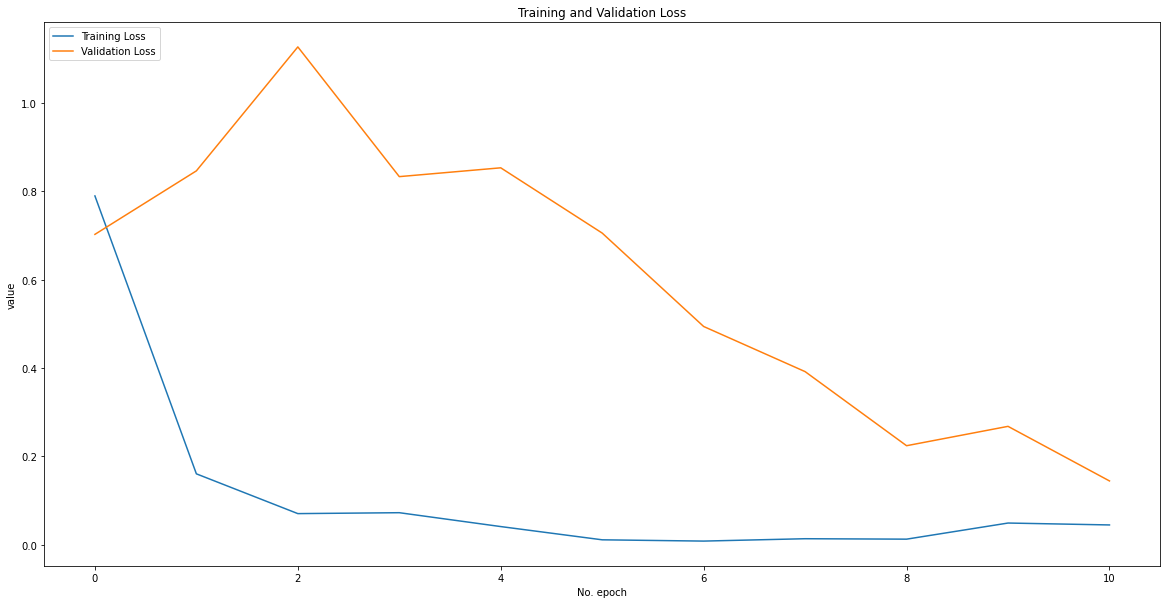

In [30]:
# Ploting Loss
plt.figure(figsize = (20,10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

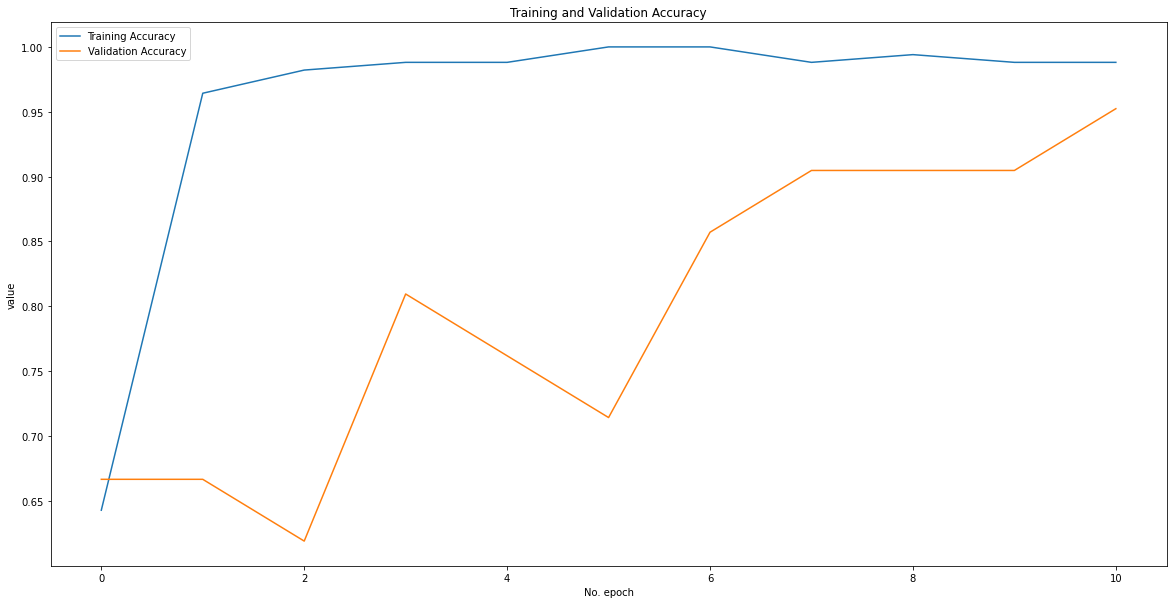

In [31]:
# Ploting Accuarcy 
plt.figure(figsize = (20,10))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **C. MODEL EVALUATION**

In [32]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 1.0000 
Loss on training data: 0.0444 

Accuracy on test data: 1.0000 
Loss on test data: 0.0350 



In [33]:
df_te

,path,tag,set
30,gambar/bedugul/37.jpg,bedugul,test
34,gambar/bedugul/40.jpg,bedugul,test
75,gambar/besakih/14.jpg,besakih,test
152,gambar/tanahlot/20.jpg,tanahlot,test
120,gambar/besakih/55.jpg,besakih,test
37,gambar/bedugul/43.jpg,bedugul,test
192,gambar/tanahlot/57.jpg,tanahlot,test
35,gambar/bedugul/41.jpg,bedugul,test
78,gambar/besakih/17.jpg,besakih,test
90,gambar/besakih/28.jpg,besakih,test


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
def getNumber(str):
    if str=="bedugul":
        return 1
    elif str=="besakih":
        return 2
    else:
        return 0
df_te["tag"]=df_te["tag"].apply(getNumber)

df_te.head()

,path,tag,set
30,gambar/bedugul/37.jpg,1,test
34,gambar/bedugul/40.jpg,1,test
75,gambar/besakih/14.jpg,2,test
152,gambar/tanahlot/20.jpg,0,test
120,gambar/besakih/55.jpg,2,test


In [35]:
import requests
from io import BytesIO

from PIL import Image
import numpy as np

In [36]:
# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['bedugul', 'besakih','tanahlot']

In [37]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [38]:
namaImage = []
Prediksi = []
Proba = []
for i in df_te['path'] :
    string = i
    im = Image.open(string)
    X = preprocess(im,input_size)
    X = reshape([X])
    y = model.predict(X)
    namaImage.append(i)
    Prediksi.append(labels[np.argmax(y)])
    Proba.append(np.max(y))

In [39]:
test = pd.DataFrame({
    'Nama Image' : namaImage,
    'Prediksi' : Prediksi,
    'Predcit Probability' : Proba
})
test

,Nama Image,Prediksi,Predcit Probability
0,gambar/bedugul/37.jpg,bedugul,0.999991
1,gambar/bedugul/40.jpg,bedugul,1.000000
2,gambar/besakih/14.jpg,besakih,0.999281
3,gambar/tanahlot/20.jpg,tanahlot,0.998766
4,gambar/besakih/55.jpg,besakih,0.997993
5,gambar/bedugul/43.jpg,bedugul,0.999880
6,gambar/tanahlot/57.jpg,tanahlot,0.999802
7,gambar/bedugul/41.jpg,bedugul,0.962382
8,gambar/besakih/17.jpg,besakih,0.998936
9,gambar/besakih/28.jpg,besakih,0.998873


In [40]:
def getNumber(str):
    if str=="bedugul":
        return 1
    elif str=="besakih":
        return 2
    else:
        return 0
test["Prediksi"]=test["Prediksi"].apply(getNumber)

test.head()

,Nama Image,Prediksi,Predcit Probability
0,gambar/bedugul/37.jpg,1,0.999991
1,gambar/bedugul/40.jpg,1,1.000000
2,gambar/besakih/14.jpg,2,0.999281
3,gambar/tanahlot/20.jpg,0,0.998766
4,gambar/besakih/55.jpg,2,0.997993


In [41]:
y_true=df_te["tag"]
y_true

30     1
34     1
75     2
152    0
120    2
37     1
192    0
35     1
78     2
90     2
0      1
196    0
9      1
116    2
129    2
156    0
144    0
189    0
21     1
175    0
131    2
Name: tag, dtype: int64

In [42]:
y_pred=test["Prediksi"]
y_pred

0     1
1     1
2     2
3     0
4     2
5     1
6     0
7     1
8     2
9     2
10    1
11    0
12    1
13    2
14    1
15    0
16    0
17    0
18    1
19    0
20    2
Name: Prediksi, dtype: int64

In [43]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])


In [44]:
# Model Train
EPOCH = 6

history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/6
11/11 [==============================] - 125s 7s/step - loss: 0.1050 - accuracy: 0.9583 - f1_m: 0.9545 - precision_m: 0.9545 - recall_m: 0.9545 - val_loss: 0.7871 - val_accuracy: 0.8095 - val_f1_m: 0.8062 - val_precision_m: 0.8062 - val_recall_m: 0.8062
Epoch 2/6
11/11 [==============================] - 54s 5s/step - loss: 0.0256 - accuracy: 0.9940 - f1_m: 0.9943 - precision_m: 0.9943 - recall_m: 0.9943 - val_loss: 0.8633 - val_accuracy: 0.8571 - val_f1_m: 0.8375 - val_precision_m: 0.8375 - val_recall_m: 0.8375
Epoch 3/6
11/11 [==============================] - 53s 5s/step - loss: 0.0669 - accuracy: 0.9702 - f1_m: 0.9716 - precision_m: 0.9716 - recall_m: 0.9716 - val_loss: 0.8215 - val_accuracy: 0.8571 - val_f1_m: 0.9062 - val_precision_m: 0.9062 - val_recall_m: 0.9062
Epoch 4/6
11/11 [==============================] - 59s 5s/step - loss: 0.1108 - accuracy: 0.9702 - f1_m: 0.9716 - precision_m: 0.9716 - recall_m: 0.9716 - val_loss: 0.3813 - val_accuracy: 0.8571 - val_f1_m: 0.9

In [45]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(test_data,steps=len(test_generator), verbose=0)
print('Loss on test data: {:.4f} \nAccuracy on test data: {:.4f} \nF1-Score on test data: {:.4f} \nPrecision on test data: {:.4f} \nRecall on test data: {:.4f}'.format(loss, accuracy, f1_score, precision, recall),'\n')

Loss on test data: 0.3102 
Accuracy on test data: 0.9048 
F1-Score on test data: 0.8687 
Precision on test data: 0.8687 
Recall on test data: 0.8687 



In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[7 0 0]
 [0 7 0]
 [0 1 6]]


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       1.00      0.86      0.92         7

    accuracy                           0.95        21
   macro avg       0.96      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



# **3. PREDICTION**

In [48]:
# read image
im = Image.open('gambar/tanahlot/15.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

tanahlot 0.99826753


In [49]:
im = Image.open('gambar/bedugul/15.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)
def text(im):
    if np.max(y)>0.8:
        if labels[np.argmax(y)]=='tanahlot':
            print("""Tanah Lot
            Pura Tanah Lot adalah salah satu Pura (Tempat Ibadah Umat Hindu) yang sangat disucikan di Bali, Indonesia. Di sini ada dua pura yang terletak di atas batu besar. Satu terletak di atas bongkahan batu dan satunya terletak di atas tebing mirip dengan Pura Uluwatu. Pura Tanah Lot ini merupakan bagian dari pura Dang Kahyangan. Pura Tanah Lot merupakan pura laut tempat pemujaan dewa-dewa penjaga laut. Tanah Lot terkenal sebagai tempat yang indah untuk melihat matahari terbenam.
            Menurut sejarah Tanah Lot berdasarkan legenda Dang Hyang Nirartha memindahkan batu karang (tempat bermeditasinya) ke tengah pantai dengan kekuatan spiritual. Batu karang tersebut diberi nama Tanah Lot yang artinya batukarang yang berada di tengah lautan. Semenjak peristiwa itu Bendesa Beraban Sakti mengakui kesaktian yang dimiliki Dang Hyang Nirartha dengan menjadi pengikutnya untuk memeluk agama Hindu bersama dengan seluruh penduduk setempat.
            Dikisahkan di sejarah Tanah Lot, sebelum meninggalkan desa Beraban, Dang Hyang Nirartha memberikan sebuah keris kepada bendesa Beraban. Keris tersebut memiliki kekuatan untuk menghilangkan segala penyakit yang menyerang tanaman. Keris tersebut disimpan di Puri Kediri dan dibuatkan upacara keagamaan di Pura Tanah Lot setiap enam bulan sekali. Semenjak hal ini rutin dilakukan oleh penduduk desa Beraban, kesejahteraan penduduk sangat meningkat pesat dengan hasil panen pertanian yang melimpah dan mereka hidup dengan saling menghormati.
            Menurut legenda, pura ini dibangun oleh seorang brahmana yang mengembara dari Jawa, yaitu Danghyang Nirartha yang berhasil menguatkan kepercayaan penduduk Bali akan ajaran Hindu dan membangun Sad Kahyangan tersebut pada abad ke-16. Pada saat itu, penguasa Tanah Lot yang bernama Bendesa Beraben merasa iri kepadanya karena para pengikutnya mulai pergi untuk mengikuti Danghyang Nirartha. Bendesa Beraben kemudian menyuruh Danghyang Nirartha meninggalkan Tanah Lot. Danghyang Nirartha menyanggupi, tetapi sebelumnya ia dengan kekuatannya memindahkan Bongkahan Batu ke tengah pantai (bukan ke tengah laut) dan membangun pura di sana. Ia juga mengubah selendangnya menjadi ular penjaga pura. Ular ini masih ada sampai sekarang dan secara ilmiah ular ini termasuk jenis ular laut yang mempunyai ciri-ciri berekor pipih seperti ikan, warna hitam berbelang kuning dan mempunyai racun 3 kali lebih kuat dari ular cobra. Akhirnya disebutkan bahwa Bendesa Beraben menjadi pengikut Danghyang Nirartha.
            Objek wisata tanah lot terletak di Desa Beraban, Kecamatan Kediri, Kabupaten Tabanan, sekitar 13 kilometer di sebelah selatan Kota Tabanan. Di sebelah utara Pura Tanah Lot, sebuah pura lain yang dibangun di atas tebing yang menjorok ke laut. Tebing ini menghubungkan Pura dengan daratan dan berbentuk seperti jembatan (melengkung). Pura ini disebut Pura Batu Bolong.
            Pujawali (Odalan) di Pura ini diperingati setiap 210 hari sekali, sebagaimana pura lain pada biasanya. Jatuhnya dekat dengan perayaan Galungan dan Kuningan, tepatnya pada Hari Suci Buda Wage (Buda Cemeng) Langkir.""")
        elif labels[np.argmax(y)]=='besakih':
            print("""Pura Besakih
            Pura Besakih adalah sebuah kompleks pura di desa Besakih di lereng Gunung Agung, Bali timur, Indonesia. Candi Hindu terbesar dan tersuci serta salah satu rangkaian candi Bali Bertengger hampir 1000 meter di sisi Gunung Agung. Candi ini dibangun enam tingkat, bertingkat di lereng. Pintu masuk ditandai dengan candi bentar (gerbang terbelah), dan di luarnya Kori Agung adalah pintu gerbang ke halaman kedua.
            Asal usul dari candi suci ini berasal dari zaman prasejarah. Basis batu Pura Penataran Agung dan beberapa candi lainnya menyerupai piramida berundak megalitik, yang berusia setidaknya 2.000 tahun. Pura Besakih digunakan sebagai tempat ibadah Hindu dari 1284 ketika penakluk Jawa pertama menetap di Bali. Pada abad ke-15, Besakih telah menjadi kuil negara dari dinasti Gelgel yang kuat.
            Pura Besakih adalah kompleks yang terdiri dari dua puluh tiga pura yang terletak di punggung bukit paralel. Ini memiliki teras berundak dan anak tangga yang naik ke sejumlah halaman dan gerbang bata yang pada gilirannya mengarah ke menara utama atau struktur Meru , yang disebut Pura Penataran Agung. Semua ini disejajarkan di sepanjang sumbu tunggal dan dirancang untuk mengarahkan orang spiritual ke atas dan lebih dekat ke gunung yang dianggap suci. Tempat suci utama kompleks ini adalah Pura Penataran Agung. Pusat simbolis dari tempat suci utama adalah singgasana teratai, atau padmasana , yang oleh karena itu merupakan fokus ritual dari seluruh kompleks. Itu berasal dari sekitar abad ketujuh belas.
            Serangkaian letusan Gunung Agung pada tahun 1963 yang menewaskan kurang lebih 1.700 orang juga mengancam Pura Besakih. Aliran lava melewatkan kompleks candi hanya beberapa meter. Penyelamatan candi dianggap oleh masyarakat Bali sebagai keajaiban, dan sinyal dari para dewa bahwa mereka ingin menunjukkan kekuatan mereka tetapi tidak menghancurkan monumen yang telah didirikan oleh umat beriman Bali.
            Setiap tahun setidaknya ada tujuh puluh festival yang diadakan di kompleks tersebut, karena hampir setiap kuil merayakan hari jadi tahunan. Siklus ini didasarkan pada tahun kalender Pawukon Bali 210 hari. Itu telah dinominasikan sebagai Situs Warisan Dunia pada awal 1995, tetapi ditarik keluar pada 2015.""")
        else :
            print ("""Pura Ulun Danu Bratan Bedugul
            Pura Ulun Danu merupakan warisan pura kuno di Bali dari jaman leluhur tempo dulu. Asal nama Bedugul dari kata “bedug” dan “kul-kul”, dua kata tersebut merupakan dua buah alat yang menghasilkan bunyi-bunyian. Bedug merupakan alat musik khas umat muslim dan diletakkan juga di masjid-masjid, sedangkan Kul-kul adalah kentongan yang digunakan sebagai tanda untuk komunikasi masyarakat Bali.
            Pura Ulun Danu di Danau Beratan Bedugul dikutip dalam lontar Babad Mengwi, bahwa di kawasan ini terdapat dua peninggalan sejarah yaitu sarkopagus dan juga papan batu yang berasal dari jaman Megalitikum. Jadi Pura Ulun Danu sudah digunakan sebagai tempat melakukan ritual sejak jaman megalitikum. Kedua artefak tersebut sekarang diletakkan di dalam pura.
            Tidak ada angka tahun yang jelas kapan berdirinya pura tersebut. Namun dalam Lontar Babad Mengwi tersebut disebutkan bahwa pura Taman Ayun dipelas pada Anggara Kliwon Medangsia tahun Saka Sad Bhuta Yaksa Dewaya tahun 1634 Masehi atau Isaka 1556.
            Berdasarkan tahun berdirinya pura Taman Ayun di Mengwi, maka dipastikan pura Ulun Danu di danau Beratan Bedugul tersebut didirikan sebelum tahun 1634 Masehi, sedangkan artefak yang ada di pura tersebut diperkirakan sudah ada 500 tahun sebelum masehi.
            Kawasan Pura Ulun Danu di danau Beratan Bedugul tersebut memiliki 5 buah komplek pura dan satu stupa Budha, ini menandakan saat berdirinya pura Ulun Danu tersebut sudah terjadi akulturasi budaya Hindu dengan Budha yang merupakan keselarasan dan harmoni antar umat beragama.""")
    else:
        print('Input gambar lagi')
text(im)

Pura Ulun Danu Bratan Bedugul
            Pura Ulun Danu merupakan warisan pura kuno di Bali dari jaman leluhur tempo dulu. Asal nama Bedugul dari kata “bedug” dan “kul-kul”, dua kata tersebut merupakan dua buah alat yang menghasilkan bunyi-bunyian. Bedug merupakan alat musik khas umat muslim dan diletakkan juga di masjid-masjid, sedangkan Kul-kul adalah kentongan yang digunakan sebagai tanda untuk komunikasi masyarakat Bali.
            Pura Ulun Danu di Danau Beratan Bedugul dikutip dalam lontar Babad Mengwi, bahwa di kawasan ini terdapat dua peninggalan sejarah yaitu sarkopagus dan juga papan batu yang berasal dari jaman Megalitikum. Jadi Pura Ulun Danu sudah digunakan sebagai tempat melakukan ritual sejak jaman megalitikum. Kedua artefak tersebut sekarang diletakkan di dalam pura.
            Tidak ada angka tahun yang jelas kapan berdirinya pura tersebut. Namun dalam Lontar Babad Mengwi tersebut disebutkan bahwa pura Taman Ayun dipelas pada Anggara Kliwon Medangsia tahun Saka Sad 

In [50]:
data_pred = pd.read_csv('coba.csv')
data_pred 

,id
0,1t
1,2t
2,3t
3,1b
4,2b
5,3b
6,1be
7,2be
8,3be


In [51]:
namaImage = []
Prediksi = []
Proba = []
for i in data_pred['id'] :
    string = 'Testing/'+i+'.jpg'
    im = Image.open(string)
    X = preprocess(im,input_size)
    X = reshape([X])
    y = model.predict(X)
    namaImage.append(i)
    Prediksi.append(labels[np.argmax(y)])
    Proba.append(np.max(y))

In [52]:
new_data = pd.DataFrame({
    'Nama Image' : namaImage,
    'Prediksi' : Prediksi,
    'Predcit Probability' : Proba
})

In [53]:
new_data

,Nama Image,Prediksi,Predcit Probability
0,1t,tanahlot,0.997887
1,2t,tanahlot,0.986379
2,3t,tanahlot,0.999813
3,1b,besakih,0.999995
4,2b,besakih,0.999989
5,3b,besakih,0.999997
6,1be,bedugul,0.999987
7,2be,bedugul,0.858389
8,3be,besakih,0.906910


In [64]:
model.save('model.h5')